#### Computer Vison TA - 2 (Mini Project)

##### Name : Ashwini bisen
##### Roll  No. : 03(A)

#### Robust Image Stitching for Panorama Creation
##### Objective: Automatically stitch two or more overlapping images to create a seamless panorama using SIFT, RANSAC, and Harris Corner Detector.



##### Imagine you have taken multiple overlapping photos of a landscape, and you want to merge them into a single wide-view panorama. A combination of feature detection, keypoint matching, and transformation estimation is needed to align the images properly.

#### Step 1: Feature Detection & Matching (SIFT) : Detect keypoints and descriptors in the input images 
#### Step 2: Outlier Removal & Transformation Estimation (RANSAC)  : To remove incorrect matches and estimate the homography 
#### Step 3:  Corner Detection for Image Alignment (Harris Corner Detector) : To find the best overlapping points in both images.

In [61]:
# pip install opencv-python numpy matplotlib

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

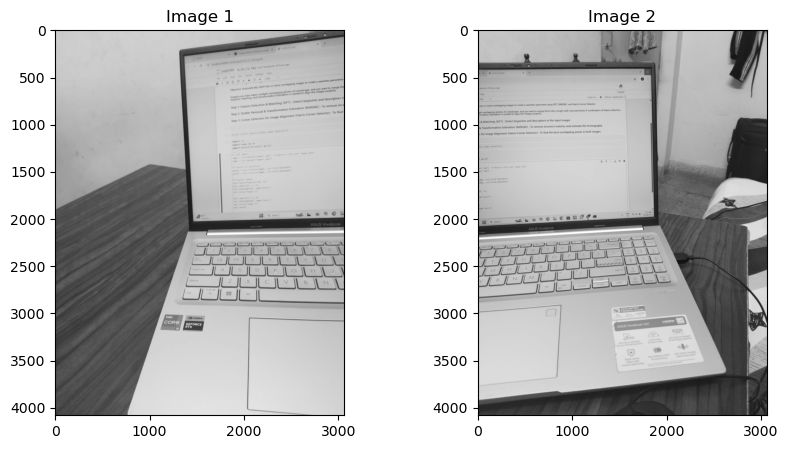

In [9]:
img1 = cv2.imread("C:/Users/cw/Downloads/image_1.jpg")  # Replace with your image path
img2 = cv2.imread("C:/Users/cw/Downloads/image_2.jpg")

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(gray1, cmap="gray")
plt.title("Image 1")

plt.subplot(1, 2, 2)
plt.imshow(gray2, cmap="gray")
plt.title("Image 2")
plt.show()


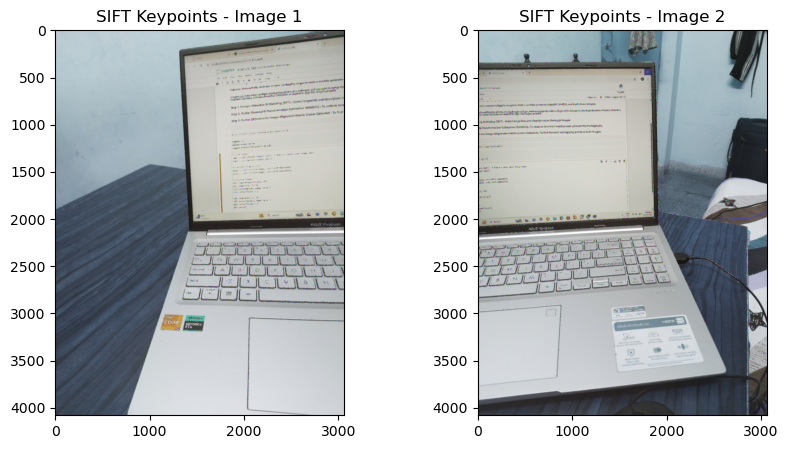

In [10]:
# Create SIFT detector
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

img1_kp = cv2.drawKeypoints(img1, kp1, None)
img2_kp = cv2.drawKeypoints(img2, kp2, None)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1_kp)
plt.title("SIFT Keypoints - Image 1")

plt.subplot(1, 2, 2)
plt.imshow(img2_kp)
plt.title("SIFT Keypoints - Image 2")
plt.show()


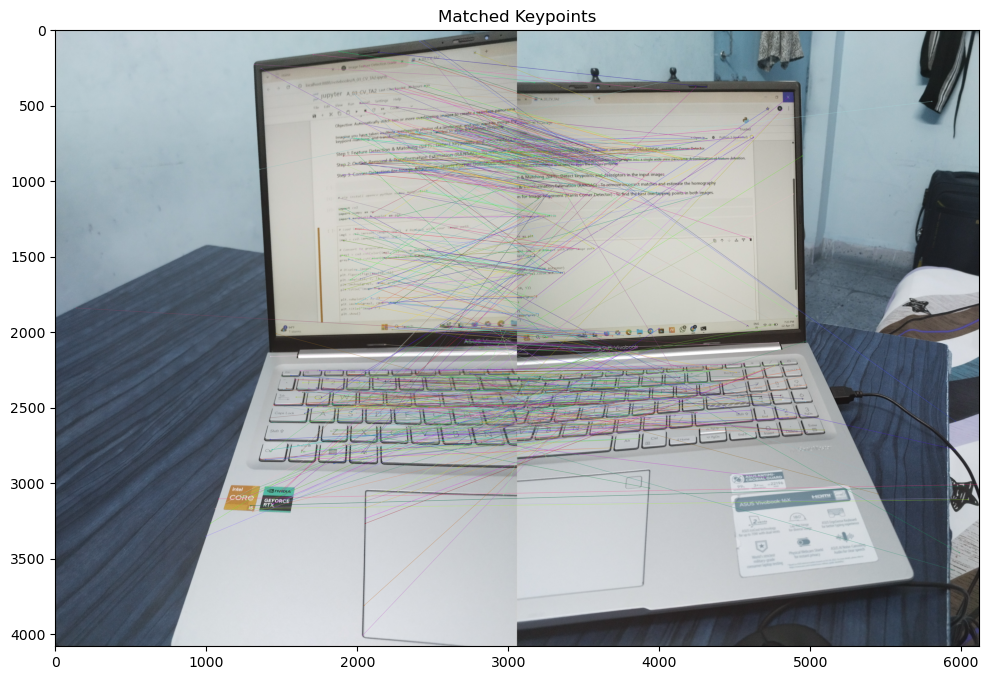

In [11]:
# FLANN matcher
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Find matches
matches = flann.knnMatch(des1, des2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

matched_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 8))
plt.imshow(matched_img)
plt.title("Matched Keypoints")
plt.show()


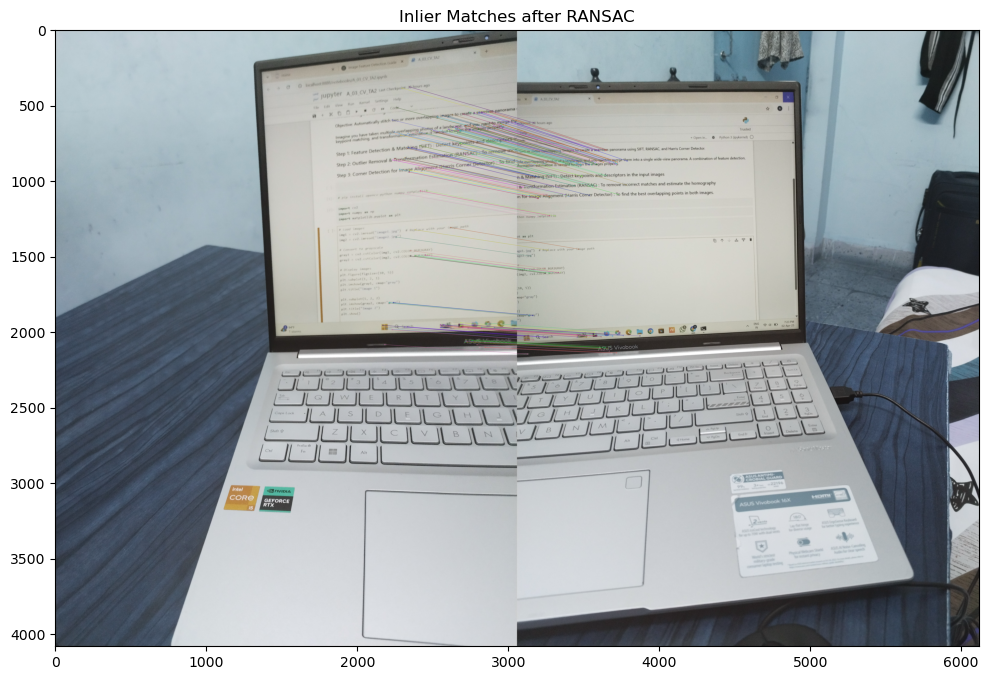

In [12]:
# Extracted matched keypoints
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Computig homography with RANSAC
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

inliers = [good_matches[i] for i in range(len(good_matches)) if mask[i]]

inlier_img = cv2.drawMatches(img1, kp1, img2, kp2, inliers, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 8))
plt.imshow(inlier_img)
plt.title("Inlier Matches after RANSAC")
plt.show()


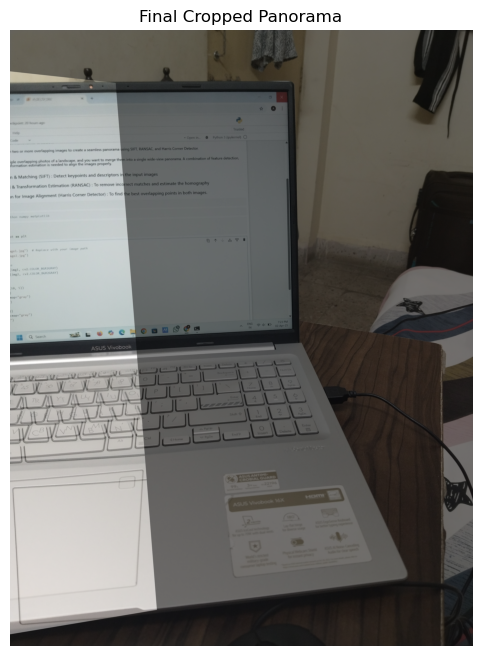

In [13]:
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]

warped_img1 = cv2.warpPerspective(img1, H, (w1 + w2, max(h1, h2)))

stitched_image = np.zeros_like(warped_img1)
stitched_image[0:h2, 0:w2] = img2  # Place Image 2

stitched_image = cv2.addWeighted(stitched_image, 0.5, warped_img1, 0.5, 0)

gray = cv2.cvtColor(stitched_image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

# Finding contours for Harris Corner detection
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
x, y, w, h = cv2.boundingRect(contours[0])

stitched_cropped = stitched_image[y:y+h, x:x+w]

plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(stitched_cropped, cv2.COLOR_BGR2RGB))
plt.title("Final Cropped Panorama")
plt.axis("off")
plt.show()
